In [1]:
from LDA_XGB.pipeline import CopathologyPipeline
from LDA_XGB.data_processor import *
from LDA_XGB.visualizer import CopathologyVisualizer
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
# Optional: pip install statannotations if not installed
from statannotations.Annotator import Annotator

path_all_dx_k_18 = 'C:/Users/WooSikKim/Desktop/Research/projects/co_pathology/scripts/stage_copath/STAGE_CoPathology/LDA_XGB/models/wsev_smc_all_dx_with_cn_k_18.pkl'
mdl_all_dx_k_18 = CopathologyPipeline.load(path_all_dx_k_18)
print(mdl_all_dx_k_18._region_cols)

Pipeline loaded from C:/Users/WooSikKim/Desktop/Research/projects/co_pathology/scripts/stage_copath/STAGE_CoPathology/LDA_XGB/models/wsev_smc_all_dx_with_cn_k_18.pkl
['VA/2', 'VA/4', 'VA/5', 'VA/7', 'VA/8', 'VA/10', 'VA/11', 'VA/12', 'VA/13', 'VA/14', 'VA/15', 'VA/16', 'VA/17', 'VA/18', 'VA/24', 'VA/26', 'VA/28', 'VA/31', 'VA/41', 'VA/43', 'VA/44', 'VA/46', 'VA/47', 'VA/49', 'VA/50', 'VA/51', 'VA/52', 'VA/53', 'VA/54', 'VA/58', 'VA/60', 'VA/63', 'VA/77', 'VA/1002', 'VA/1003', 'VA/1005', 'VA/1006', 'VA/1007', 'VA/1008', 'VA/1009', 'VA/1010', 'VA/1011', 'VA/1012', 'VA/1013', 'VA/1014', 'VA/1015', 'VA/1016', 'VA/1017', 'VA/1018', 'VA/1019', 'VA/1020', 'VA/1021', 'VA/1022', 'VA/1023', 'VA/1024', 'VA/1025', 'VA/1026', 'VA/1027', 'VA/1028', 'VA/1029', 'VA/1030', 'VA/1031', 'VA/1034', 'VA/1035', 'VA/2002', 'VA/2003', 'VA/2005', 'VA/2006', 'VA/2007', 'VA/2008', 'VA/2009', 'VA/2010', 'VA/2011', 'VA/2012', 'VA/2013', 'VA/2014', 'VA/2015', 'VA/2016', 'VA/2017', 'VA/2018', 'VA/2019', 'VA/2020', 'V

In [2]:
nacc_data_path = 'C:/Users/WooSikKim/Desktop/Research/projects/co_pathology/scripts/stage_copath/data/nacc'
raw_nacc_df = pd.read_csv(os.path.join(nacc_data_path, 'NACC_external_260212_all_dx_lda_k_18.csv'))
cn_nacc_df = raw_nacc_df[raw_nacc_df['DX']=='CN']
raw_nacc_df['copath'] = raw_nacc_df['copath'].replace('NC+PD','PD')
# raw_nacc_df = raw_nacc_df[~raw_nacc_df['copath'].str.contains('NC', na=False)]
raw_nacc_df = raw_nacc_df[
    ~raw_nacc_df['copath'].str.contains('NC|MCI|iMCI', na=False)
]
raw_nacc_df.dropna(subset='copath', inplace=True)

lda_dx_topic_mean_df = pd.read_csv('C:/Users/WooSikKim/Desktop/Research/projects/co_pathology/scripts/stage_copath/results/wsev_smc_all_dx/18/lda_diagnosis_topic_expression.csv')
lda_dx_topic_mean_df = lda_dx_topic_mean_df[lda_dx_topic_mean_df['DX']!='NC']
lda_dx_topic_mean_df['DX'] = lda_dx_topic_mean_df['DX'].replace('DLB', 'LBD')


lda_dx_topic_manual_df = pd.read_csv('C:/Users/WooSikKim/Desktop/Research/projects/co_pathology/scripts/stage_copath/results/wsev_smc_all_dx/18/lda_diagnosis_topic_manual_weights.csv')
lda_dx_topic_manual_df = lda_dx_topic_manual_df[lda_dx_topic_manual_df['DX']!='NC']
lda_dx_topic_manual_df['DX'] = lda_dx_topic_manual_df['DX'].replace('DLB', 'LBD')


print(raw_nacc_df['copath'].value_counts())
topic_cols = [f'Topic_{i}' for i in range(18)]
va_cols =  raw_nacc_df.loc[:,'VA/2':'VA/2035'].columns

copath
AD                334
AD+VD              50
FTD_ANY            40
LBD                24
AD+PCA             22
PD                 20
AD+LBD             17
VD                  9
AD+FTD_ANY          8
PD+LBD              4
LBD+VD              3
VD+FTD_ANY          3
LBD+VD+SVAD         3
VD+SVAD             2
AD+VD+SVAD          2
AD+LBD+PCA          2
AD+LBD+VD           1
AD+PD+LBD           1
AD+VD+FTD_ANY       1
LBD+FTD_ANY         1
AD+LBD+FTD_ANY      1
AD+PD               1
AD+VD+PCA           1
AD+SVAD             1
Name: count, dtype: int64


In [3]:
## COMPUTE NACC ND VALUES ##
nacc_data_processor = DataProcessor(
    region_cols=va_cols,
    dx_col = 'DX',
    subject_col = 'FULL_ID'
)
nacc_data_processor.fit_baseline(hc_data=cn_nacc_df)
nacc_Z = nacc_data_processor.compute_atrophy_scores(data=raw_nacc_df)

import pandas as pd

# convert ndarray → df with proper columns + index
nacc_Z_df = pd.DataFrame(
    nacc_Z,
    columns=va_cols,
    index=raw_nacc_df.index
)

# (optional) rename to indicate Z-scores
nacc_Z_df = nacc_Z_df.add_suffix('_ND')

# append back to original df
raw_nacc_df = pd.concat([raw_nacc_df, nacc_Z_df], axis=1)

In [4]:
## Raw VA x Topicwise ROI ##
lda_topic_roi_df = pd.read_csv('C:/Users/WooSikKim/Desktop/Research/projects/co_pathology/scripts/stage_copath/results/wsev_smc_all_dx/18/lda_topic_atrophy_patterns.csv')
lda_topic_roi_df = lda_topic_roi_df.rename(columns={lda_topic_roi_df.columns[0]: 'ROI'})
top10_rois = {}
for col in lda_topic_roi_df.columns[1:]:  # skip ROI column
    top10 = lda_topic_roi_df[['ROI', col]].nlargest(10, col)
    top10_rois[col] = top10

for topic, top10 in top10_rois.items():

    # --- ROI names from topic df ---
    rois = top10['ROI'].values

    # --- map to zscore column names ---
    z_rois = [f'{r}_ND' for r in rois]

    # --- keep only those that exist in raw_nacc_df ---
    common_mask = [zr in raw_nacc_df.columns for zr in z_rois]

    rois_common = rois[common_mask]
    z_rois_common = [f'{r}_ND' for r in rois_common]

    # subset again to match order
    top10_common = top10[top10['ROI'].isin(rois_common)]
    weights_common = top10_common[topic].values

    # --- Z-score weighted multiplication ---
    weighted_vals = raw_nacc_df[z_rois_common].values * weights_common

    # --- Sum across Top10 ROIs ---
    raw_nacc_df[f'{topic}_top10_weighted_z'] = weighted_vals.sum(axis=1)


In [5]:
manual_weights = {
    'AD':  {2: 0.5, 12: 0.2, 13: 0.3},
    'LBD': {6: 0.4, 10: 0.6},
    'PD': {0: 0.4, 10: 0.6},
    'bvFTD': {1: 0.4, 12: 0.2, 13: 0.4},
    'nfvPPA': {0: 0.5, 1: 0.5},
    'svPPA': {12: 0.5, 13: 0.5},
    'SVAD': {6: 0.4, 10: 0.6}
} # Manual Ratios of each DX weights 
manual_weights_df = pd.DataFrame(manual_weights)
weighted_cols = [f'Topic_{i}_top10_weighted_z' for i in range(18)]


for dx in lda_dx_topic_manual_df['DX']:
    mean_vec = lda_dx_topic_manual_df.loc[lda_dx_topic_manual_df['DX'] == dx, topic_cols].values.flatten()
    raw_nacc_df[f'ND_{dx}'] = raw_nacc_df[weighted_cols].values @ mean_vec

############## MEAN WEIGHTS VERSION ##############
# for dx in lda_dx_topic_mean_df['DX']:
    
#     # get original topic means of this DX
#     dx_means = lda_dx_topic_mean_df.loc[
#         lda_dx_topic_mean_df['DX'] == dx, topic_cols
#     ].values.flatten()
    
#     # initialize new weighted vector (all zeros)
#     weighted_mean_vec = np.zeros(len(weighted_cols))
    
#     # apply manual weights if DX is predefined
#     if dx in manual_weights:
#         print(dx)
#         for topic_idx, weight in manual_weights[dx].items():
#             print(topic_idx, weight)
#             weighted_mean_vec[topic_idx] = dx_means[topic_idx] * weight
    
#     # projection
#     raw_nacc_df[f'ND_{dx}'] = raw_nacc_df[weighted_cols].values @ weighted_mean_vec
##################33 MEAN WEIGHTS VERSION ################3
    
copath_dfs = {grp: subdf.copy() for grp, subdf in raw_nacc_df.groupby('copath')}
nd_cols = [col for col in raw_nacc_df.columns if col.startswith('ND_')]


AD


C:\Users\WooSikKim\AppData\Local\Temp\ipykernel_22632\3381943973.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


AD+FTD_ANY
AD+LBD


C:\Users\WooSikKim\AppData\Local\Temp\ipykernel_22632\3381943973.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\WooSikKim\AppData\Local\Temp\ipykernel_22632\3381943973.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


AD+LBD+PCA
AD+PCA


C:\Users\WooSikKim\AppData\Local\Temp\ipykernel_22632\3381943973.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\WooSikKim\AppData\Local\Temp\ipykernel_22632\3381943973.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


AD+VD


C:\Users\WooSikKim\AppData\Local\Temp\ipykernel_22632\3381943973.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


AD+VD+SVAD
FTD_ANY


C:\Users\WooSikKim\AppData\Local\Temp\ipykernel_22632\3381943973.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\WooSikKim\AppData\Local\Temp\ipykernel_22632\3381943973.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


LBD


C:\Users\WooSikKim\AppData\Local\Temp\ipykernel_22632\3381943973.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


LBD+VD


C:\Users\WooSikKim\AppData\Local\Temp\ipykernel_22632\3381943973.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


LBD+VD+SVAD
PD


C:\Users\WooSikKim\AppData\Local\Temp\ipykernel_22632\3381943973.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\WooSikKim\AppData\Local\Temp\ipykernel_22632\3381943973.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


PD+LBD
VD
VD+FTD_ANY


C:\Users\WooSikKim\AppData\Local\Temp\ipykernel_22632\3381943973.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\WooSikKim\AppData\Local\Temp\ipykernel_22632\3381943973.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\WooSikKim\AppData\Local\Temp\ipykernel_22632\3381943973.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


VD+SVAD


C:\Users\WooSikKim\AppData\Local\Temp\ipykernel_22632\3381943973.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


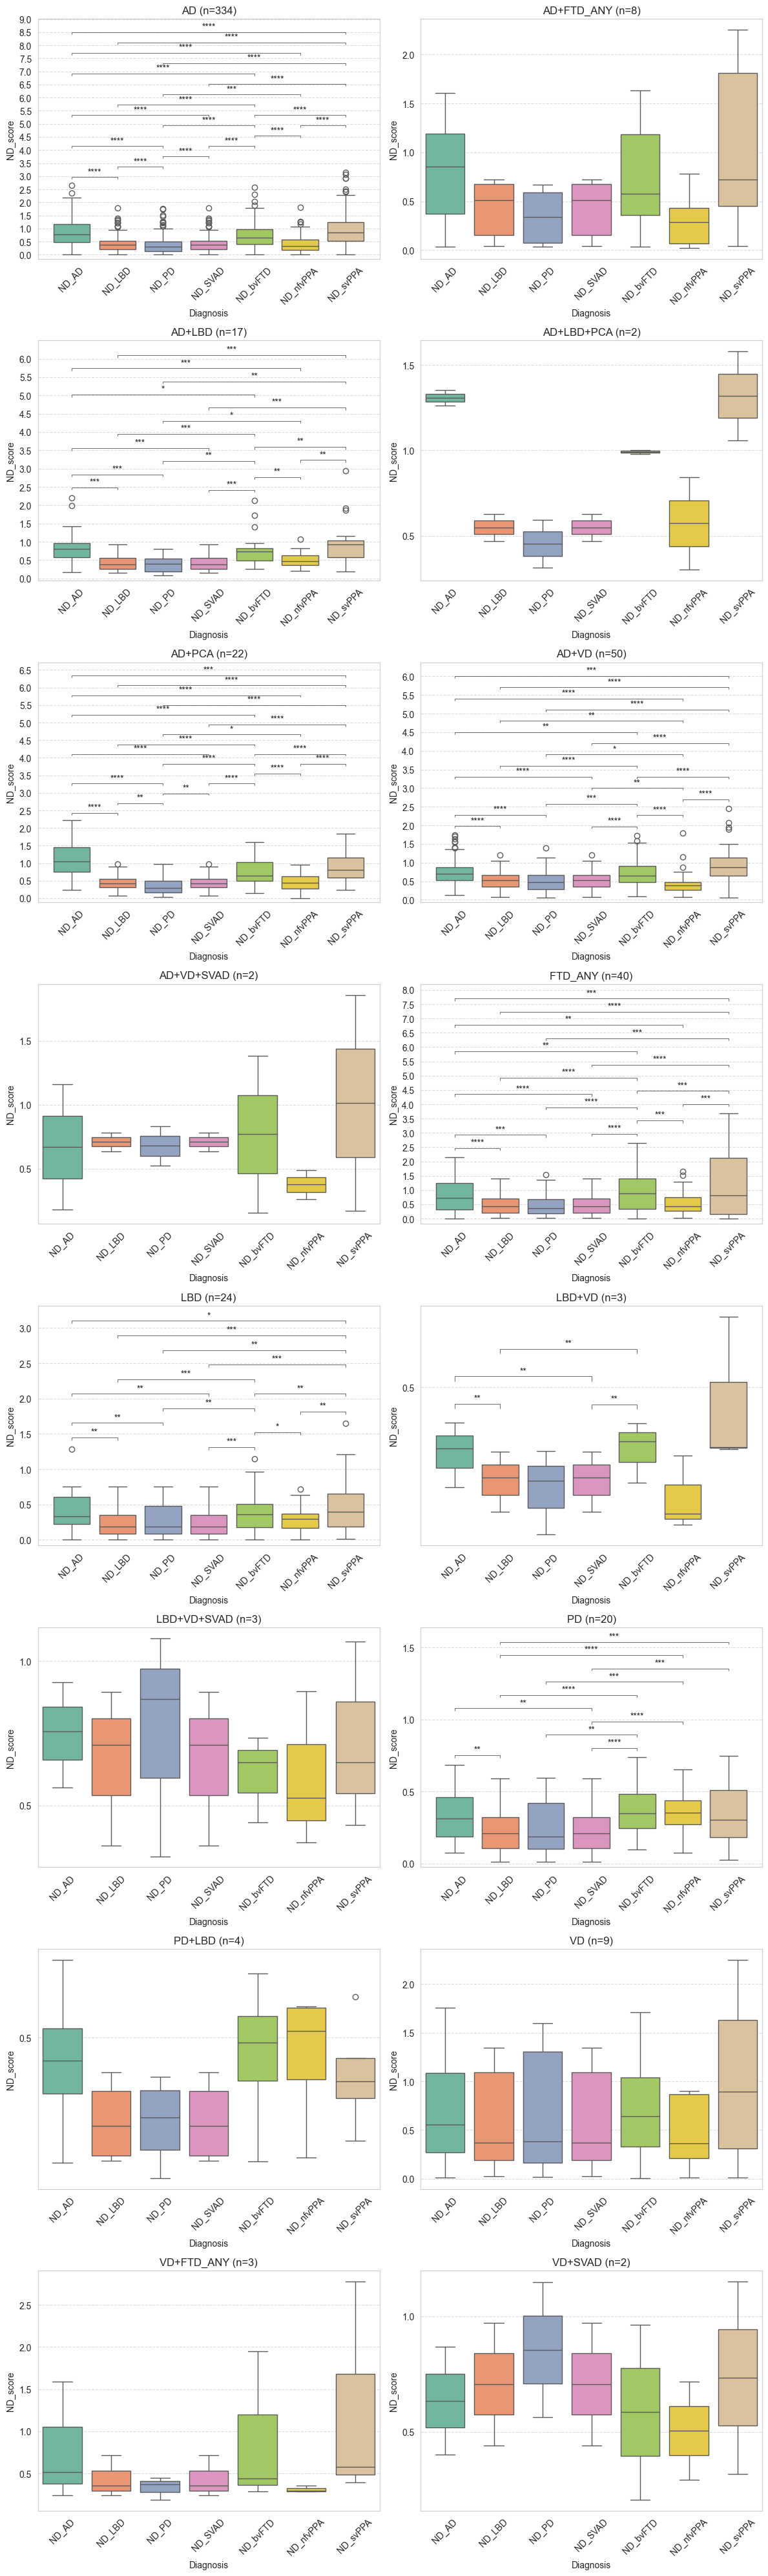

In [15]:
from statannotations.Annotator import Annotator
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

# ---------------------------
# Filter out subgroups with only 1 subject
# ---------------------------
filtered_copath_dfs = {grp: subdf for grp, subdf in copath_dfs.items() if len(subdf) > 1}
box_colors = sns.color_palette("Set2", n_colors=len(nd_cols))

num_subgroups = len(filtered_copath_dfs)
cols = 2
rows = int(np.ceil(num_subgroups / cols))
fig, axes = plt.subplots(rows, cols, figsize=(12, 5*rows))
axes = axes.flatten()

# Common y-limits across all remaining ND scores
# 1️⃣ Compute common y-limits BEFORE the loop
y_min = raw_nacc_df[nd_cols].min().min() * 0.95
y_max = raw_nacc_df[nd_cols].max().max() * 1.05
if y_max < 0.7:
    y_max = 0.7

# 2️⃣ Start plotting subplots
for i, (grp, subdf) in enumerate(filtered_copath_dfs.items()):
    print(grp)
    
    # Melt ND scores for plotting
    melted = subdf.melt(
        value_vars=nd_cols,
        var_name='Diagnosis',
        value_name='ND_score'
    )
    
    ax = axes[i]
    
    # --- Boxplot ---
    sns.boxplot(
        data=melted,
        x='Diagnosis',
        y='ND_score',
        palette=box_colors,
        ax=ax
    )
    
    # --- Quick edit: set same y-limits for all subplots ---
    # ax.set_ylim(y_min, y_max)
    
    # Title with subject count
    ax.set_title(f"{grp} (n={len(subdf)})", fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    # after plotting the boxplot
    ax.yaxis.set_major_locator(mticker.MultipleLocator(0.5))  # grid every 0.1 units
    # ax.yaxis.set_major_locator(mticker.MultipleLocator(0.25))  # grid every 0.1 units
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # --- t-test annotations (only significant) ---
    try:
        # pairs = [(a, b) for idx, a in enumerate(nd_cols) for b in nd_cols[idx+1:]]
        pairs = []
        for i_dx, dx1 in enumerate(nd_cols[:-1]):
            for dx2 in nd_cols[i_dx+1:]:
                pairs.append((dx1, dx2))  # draw comparisons sequentially

        annotator = Annotator(ax, pairs, data=melted, x='Diagnosis', y='ND_score')
        annotator.configure(
            test='t-test_paired',
            text_format='star',
            loc='inside',
            hide_non_significant=True,
            verbose=0,
            # comparisons_correction='bonferroni',
            comparisons_correction='BH',
            line_width=0.5
        )
        annotator.apply_and_annotate()
    except Exception as e:
        print(f"Statannotations skipped for {grp}: {e}")
        
    # ax.set_ylim(y_min, 4.0)

# Remove unused axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
